In [1]:
from hydrogenCommunity import hydrogenCommunity
import numpy as np
import pandas as pd

In [2]:
building_list = [('inputs/building1.csv', 10), ('inputs/building2.csv', 10), ('inputs/building3.csv', 10)]
pv_list = [('inputs/pv1.csv', 10), ('inputs/pv2.csv', 10), ('inputs/pv3.csv', 10)]
vehicle_list = ['inputs/vehicle_atHomeSchd.csv', ('inputs/vehicle1.csv', 100, 300, 3), 
               ('inputs/vehicle2.csv', 100, 300, 3), ('inputs/vehicle3.csv', 100, 300, 3)]

In [3]:
env = hydrogenCommunity(building_list, pv_list, vehicle_list)

C:\Users\wangz\anaconda3\envs\alphaHydrogen\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
env.obs_names

['buildingLoad',
 'pvGeneration',
 'vehicle_park_0',
 'vehicle_park_1',
 'vehicle_park_2',
 'vehicle_park_3',
 'vehicle_park_4',
 'vehicle_park_5',
 'vehicle_park_6',
 'vehicle_park_7',
 'vehicle_park_8',
 'vehicle_max_dist_0',
 'vehicle_max_dist_1',
 'vehicle_max_dist_2',
 'vehicle_max_dist_3',
 'vehicle_max_dist_4',
 'vehicle_max_dist_5',
 'vehicle_max_dist_6',
 'vehicle_max_dist_7',
 'vehicle_max_dist_8',
 'vehicle_tank_0',
 'vehicle_tank_1',
 'vehicle_tank_2',
 'vehicle_tank_3',
 'vehicle_tank_4',
 'vehicle_tank_5',
 'vehicle_tank_6',
 'vehicle_tank_7',
 'vehicle_tank_8']

In [5]:
env.action_names

['vehicle_0',
 'vehicle_1',
 'vehicle_2',
 'vehicle_3',
 'vehicle_4',
 'vehicle_5',
 'vehicle_6',
 'vehicle_7',
 'vehicle_8']

In [6]:
state = env.reset()

In [7]:
state

[6.0,
 0.0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 75.0,
 75.0,
 75.0,
 60.0,
 60.0,
 60.0,
 45.0,
 45.0,
 45.0,
 2800.0,
 2800.0,
 2800.0,
 2800.0,
 2800.0,
 2800.0,
 2800.0,
 2800.0,
 2800.0]

## Test a simple controller
Check vehicle H2 tank every 5am. Charge the vehicle tank to full when tank is less than 30% of full capacity.

At every 9pm, randomly discharge one vehicle at 0.5g/s for an hour (4.3kW)

In [8]:
from random import randint

In [9]:
def check_and_charge(vehicle):
    if vehicle.tankVol < vehicle.tankCapacity*0.3:
        action = vehicle.maxH2ChargingCapacity
    else:
        action = 0
    return action    

In [10]:
env.time_step_idx

0

In [11]:
env.timeIndex

DatetimeIndex(['2019-01-01 00:00:00', '2019-01-01 01:00:00',
               '2019-01-01 02:00:00', '2019-01-01 03:00:00',
               '2019-01-01 04:00:00', '2019-01-01 05:00:00',
               '2019-01-01 06:00:00', '2019-01-01 07:00:00',
               '2019-01-01 08:00:00', '2019-01-01 09:00:00',
               ...
               '2019-12-31 14:00:00', '2019-12-31 15:00:00',
               '2019-12-31 16:00:00', '2019-12-31 17:00:00',
               '2019-12-31 18:00:00', '2019-12-31 19:00:00',
               '2019-12-31 20:00:00', '2019-12-31 21:00:00',
               '2019-12-31 22:00:00', '2019-12-31 23:00:00'],
              dtype='datetime64[ns]', length=8760, freq='H')

In [12]:
env.timeIndex[env.time_step_idx].hour

0

In [13]:
def gym_simulate(building_list, pv_list, vehicle_list):
    '''
    '''
    env = hydrogenCommunity(building_list, pv_list, vehicle_list)
    vehicles_number = len(env.vehicles)
    dischargeRate = 0.5
    
    state_data = []
    action_data = []
    reward_data = []
    
    state = env.reset()
    for _ in range(env.n_steps):
        ############## Select Action ################### 
        time = env.timeIndex[env.time_step_idx]
        currentHour = time.hour
        if currentHour == 5:
            actions = []
            for vehicle in env.vehicles:
                action = check_and_charge(vehicle)
                actions.append(action)
            actions = np.array(actions)
            print(f'{time}: charge rate: {actions}')
        elif currentHour == 20:
            actions = np.zeros(vehicles_number)
            vehicle_idx = randint(0, vehicles_number-1)
            actions[vehicle_idx] = -dischargeRate
            print(f'{time}: discharge - {vehicle_idx}, discharge rate: {actions}')
        else:
            actions = np.zeros(vehicles_number)                
        ############## Simulate ################### 
        new_state, rewards, done, _ = env.step(actions)
        
        state_data.append(state)
        action_data.append(actions)
        reward_data.append(rewards)
        
        state = new_state
        if done:
            # actions_data = buffer.action_data()
            states = pd.DataFrame(state_data, columns=env.obs_names, index=env.timeIndex)
            actions = pd.DataFrame(action_data, columns=env.action_names, index=env.timeIndex)
            rewards = pd.DataFrame(reward_data, columns=['gridLoad','h2Charge'], index=env.timeIndex)
            
            # obs_data.to_csv('result_ep{0}.csv'.format(ep))
    return states, actions, rewards

In [14]:
states, actions, rewards = gym_simulate(building_list, pv_list, vehicle_list)

C:\Users\wangz\anaconda3\envs\alphaHydrogen\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


2019-01-01 05:00:00: charge rate: [0 0 0 0 0 0 0 0 0]
2019-01-01 20:00:00: discharge - 6, discharge rate: [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0. ]
2019-01-02 05:00:00: charge rate: [100. 100. 100.   0.   0.   0. 100. 100. 100.]
2019-01-02 20:00:00: discharge - 3, discharge rate: [ 0.   0.   0.  -0.5  0.   0.   0.   0.   0. ]
2019-01-03 05:00:00: charge rate: [  0.   0.   0. 100. 100. 100.   0.   0.   0.]
2019-01-03 20:00:00: discharge - 5, discharge rate: [ 0.   0.   0.   0.   0.  -0.5  0.   0.   0. ]
2019-01-04 05:00:00: charge rate: [0 0 0 0 0 0 0 0 0]
2019-01-04 20:00:00: discharge - 1, discharge rate: [ 0.  -0.5  0.   0.   0.   0.   0.   0.   0. ]
2019-01-05 05:00:00: charge rate: [100. 100. 100. 100. 100. 100.   0.   0.   0.]
2019-01-05 20:00:00: discharge - 6, discharge rate: [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0. ]
2019-01-06 05:00:00: charge rate: [  0.   0.   0.   0.   0.   0. 100. 100. 100.]
2019-01-06 20:00:00: discharge - 2, discharge rate: [ 0.   0.  -0.5  0.  

2019-02-18 05:00:00: charge rate: [100. 100. 100.   0.   0.   0.   0.   0.   0.]
2019-02-18 20:00:00: discharge - 3, discharge rate: [ 0.   0.   0.  -0.5  0.   0.   0.   0.   0. ]
2019-02-19 05:00:00: charge rate: [  0.   0.   0. 100. 100. 100.   0.   0.   0.]
2019-02-19 20:00:00: discharge - 8, discharge rate: [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5]
2019-02-20 05:00:00: charge rate: [  0.   0.   0.   0.   0.   0. 100. 100. 100.]
2019-02-20 20:00:00: discharge - 5, discharge rate: [ 0.   0.   0.   0.   0.  -0.5  0.   0.   0. ]
2019-02-21 05:00:00: charge rate: [0 0 0 0 0 0 0 0 0]
2019-02-21 20:00:00: discharge - 1, discharge rate: [ 0.  -0.5  0.   0.   0.   0.   0.   0.   0. ]
2019-02-22 05:00:00: charge rate: [100. 100. 100. 100. 100. 100.   0.   0.   0.]
2019-02-22 20:00:00: discharge - 8, discharge rate: [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5]
2019-02-23 05:00:00: charge rate: [  0.   0.   0.   0.   0.   0. 100. 100. 100.]
2019-02-23 20:00:00: discharge - 4, discharge 

2019-04-07 05:00:00: charge rate: [  0.   0.   0. 100. 100. 100.   0.   0.   0.]
2019-04-07 20:00:00: discharge - 6, discharge rate: [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0. ]
2019-04-08 05:00:00: charge rate: [0 0 0 0 0 0 0 0 0]
2019-04-08 20:00:00: discharge - 8, discharge rate: [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5]
2019-04-09 05:00:00: charge rate: [  0.   0.   0.   0.   0.   0. 100. 100. 100.]
2019-04-09 20:00:00: discharge - 4, discharge rate: [ 0.   0.   0.   0.  -0.5  0.   0.   0.   0. ]
2019-04-10 05:00:00: charge rate: [100. 100. 100. 100. 100. 100.   0.   0.   0.]
2019-04-10 20:00:00: discharge - 1, discharge rate: [ 0.  -0.5  0.   0.   0.   0.   0.   0.   0. ]
2019-04-11 05:00:00: charge rate: [0 0 0 0 0 0 0 0 0]
2019-04-11 20:00:00: discharge - 3, discharge rate: [ 0.   0.   0.  -0.5  0.   0.   0.   0.   0. ]
2019-04-12 05:00:00: charge rate: [100. 100. 100.   0.   0.   0.   0.   0.   0.]
2019-04-12 20:00:00: discharge - 5, discharge rate: [ 0.   0.   0.   0.  

2019-05-25 05:00:00: charge rate: [0 0 0 0 0 0 0 0 0]
2019-05-25 20:00:00: discharge - 1, discharge rate: [ 0.  -0.5  0.   0.   0.   0.   0.   0.   0. ]
2019-05-26 05:00:00: charge rate: [100. 100. 100.   0.   0.   0.   0.   0.   0.]
2019-05-26 20:00:00: discharge - 6, discharge rate: [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0. ]
2019-05-27 05:00:00: charge rate: [  0.   0.   0.   0.   0.   0. 100. 100. 100.]
2019-05-27 20:00:00: discharge - 8, discharge rate: [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5]
2019-05-28 05:00:00: charge rate: [0 0 0 0 0 0 0 0 0]
2019-05-28 20:00:00: discharge - 1, discharge rate: [ 0.  -0.5  0.   0.   0.   0.   0.   0.   0. ]
2019-05-29 05:00:00: charge rate: [100. 100. 100. 100. 100. 100.   0.   0.   0.]
2019-05-29 20:00:00: discharge - 0, discharge rate: [-0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
2019-05-30 05:00:00: charge rate: [  0.   0.   0.   0.   0.   0. 100. 100. 100.]
2019-05-30 20:00:00: discharge - 7, discharge rate: [ 0.   0.   0.   0.  

2019-07-12 20:00:00: discharge - 3, discharge rate: [ 0.   0.   0.  -0.5  0.   0.   0.   0.   0. ]
2019-07-13 05:00:00: charge rate: [100. 100. 100. 100. 100. 100.   0.   0.   0.]
2019-07-13 20:00:00: discharge - 2, discharge rate: [ 0.   0.  -0.5  0.   0.   0.   0.   0.   0. ]
2019-07-14 05:00:00: charge rate: [  0.   0.   0.   0.   0.   0. 100. 100. 100.]
2019-07-14 20:00:00: discharge - 3, discharge rate: [ 0.   0.   0.  -0.5  0.   0.   0.   0.   0. ]
2019-07-15 05:00:00: charge rate: [100. 100. 100.   0.   0.   0.   0.   0.   0.]
2019-07-15 20:00:00: discharge - 7, discharge rate: [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0. ]
2019-07-16 05:00:00: charge rate: [  0.   0.   0. 100. 100. 100.   0.   0.   0.]
2019-07-16 20:00:00: discharge - 7, discharge rate: [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0. ]
2019-07-17 05:00:00: charge rate: [  0.   0.   0.   0.   0.   0. 100. 100. 100.]
2019-07-17 20:00:00: discharge - 5, discharge rate: [ 0.   0.   0.   0.   0.  -0.5  0.   0.   0. ]
2

2019-08-30 20:00:00: discharge - 5, discharge rate: [ 0.   0.   0.   0.   0.  -0.5  0.   0.   0. ]
2019-08-31 05:00:00: charge rate: [0 0 0 0 0 0 0 0 0]
2019-08-31 20:00:00: discharge - 7, discharge rate: [ 0.   0.   0.   0.   0.   0.   0.  -0.5  0. ]
2019-09-01 05:00:00: charge rate: [100. 100. 100. 100. 100. 100. 100. 100. 100.]
2019-09-01 20:00:00: discharge - 6, discharge rate: [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0. ]
2019-09-02 05:00:00: charge rate: [0 0 0 0 0 0 0 0 0]
2019-09-02 20:00:00: discharge - 0, discharge rate: [-0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
2019-09-03 05:00:00: charge rate: [0 0 0 0 0 0 0 0 0]
2019-09-03 20:00:00: discharge - 8, discharge rate: [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5]
2019-09-04 05:00:00: charge rate: [100. 100. 100.   0.   0.   0. 100. 100. 100.]
2019-09-04 20:00:00: discharge - 8, discharge rate: [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5]
2019-09-05 05:00:00: charge rate: [0 0 0 0 0 0 0 0 0]
2019-09-05 20:00:00: dischar

2019-10-18 20:00:00: discharge - 6, discharge rate: [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0. ]
2019-10-19 05:00:00: charge rate: [100. 100. 100.   0.   0.   0.   0.   0.   0.]
2019-10-19 20:00:00: discharge - 5, discharge rate: [ 0.   0.   0.   0.   0.  -0.5  0.   0.   0. ]
2019-10-20 05:00:00: charge rate: [  0.   0.   0. 100. 100. 100.   0.   0.   0.]
2019-10-20 20:00:00: discharge - 4, discharge rate: [ 0.   0.   0.   0.  -0.5  0.   0.   0.   0. ]
2019-10-21 05:00:00: charge rate: [  0.   0.   0.   0.   0.   0. 100. 100. 100.]
2019-10-21 20:00:00: discharge - 5, discharge rate: [ 0.   0.   0.   0.   0.  -0.5  0.   0.   0. ]
2019-10-22 05:00:00: charge rate: [  0.   0.   0. 100. 100. 100.   0.   0.   0.]
2019-10-22 20:00:00: discharge - 6, discharge rate: [ 0.   0.   0.   0.   0.   0.  -0.5  0.   0. ]
2019-10-23 05:00:00: charge rate: [100. 100. 100.   0.   0.   0.   0.   0.   0.]
2019-10-23 20:00:00: discharge - 2, discharge rate: [ 0.   0.  -0.5  0.   0.   0.   0.   0.   0. ]
2

2019-12-07 05:00:00: charge rate: [  0.   0.   0. 100. 100. 100.   0.   0.   0.]
2019-12-07 20:00:00: discharge - 2, discharge rate: [ 0.   0.  -0.5  0.   0.   0.   0.   0.   0. ]
2019-12-08 05:00:00: charge rate: [100. 100. 100.   0.   0.   0.   0.   0.   0.]
2019-12-08 20:00:00: discharge - 5, discharge rate: [ 0.   0.   0.   0.   0.  -0.5  0.   0.   0. ]
2019-12-09 05:00:00: charge rate: [0 0 0 0 0 0 0 0 0]
2019-12-09 20:00:00: discharge - 3, discharge rate: [ 0.   0.   0.  -0.5  0.   0.   0.   0.   0. ]
2019-12-10 05:00:00: charge rate: [  0.   0.   0. 100. 100. 100.   0.   0.   0.]
2019-12-10 20:00:00: discharge - 0, discharge rate: [-0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
2019-12-11 05:00:00: charge rate: [100. 100. 100.   0.   0.   0.   0.   0.   0.]
2019-12-11 20:00:00: discharge - 4, discharge rate: [ 0.   0.   0.   0.  -0.5  0.   0.   0.   0. ]
2019-12-12 05:00:00: charge rate: [  0.   0.   0.   0.   0.   0. 100. 100. 100.]
2019-12-12 20:00:00: discharge - 7, discharge 

In [15]:
states

,buildingLoad,pvGeneration,vehicle_park_0,vehicle_park_1,vehicle_park_2,vehicle_park_3,vehicle_park_4,vehicle_park_5,vehicle_park_6,vehicle_park_7,...,vehicle_max_dist_8,vehicle_tank_0,vehicle_tank_1,vehicle_tank_2,vehicle_tank_3,vehicle_tank_4,vehicle_tank_5,vehicle_tank_6,vehicle_tank_7,vehicle_tank_8
2019-01-01 00:00:00,6.000000,0.0,1,1,1,1,1,1,1,1,...,45.0,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000
2019-01-01 01:00:00,6.000000,0.0,1,1,1,1,1,1,1,1,...,45.0,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000
2019-01-01 02:00:00,6.000000,0.0,1,1,1,1,1,1,1,1,...,45.0,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000
2019-01-01 03:00:00,6.000000,0.0,1,1,1,1,1,1,1,1,...,45.0,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000
2019-01-01 04:00:00,6.152778,0.0,1,1,1,1,1,1,1,1,...,45.0,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,57.729167,0.0,0,0,0,0,0,0,0,0,...,45.0,1784.255369,1784.255369,1784.255369,2162.226064,2162.226064,2162.226064,4800.557222,4800.557222,4800.557222
2019-12-31 20:00:00,91.326389,0.0,1,1,1,0,0,0,1,1,...,45.0,1364.721693,921.259748,589.138632,2162.226064,2162.226064,2162.226064,4511.076540,4280.769132,4005.070208
2019-12-31 21:00:00,88.138889,0.0,1,1,1,1,1,1,1,1,...,45.0,589.138632,589.138632,0.000000,1786.460236,1384.525170,981.942776,4005.070208,4005.070208,4005.070208
2019-12-31 22:00:00,92.541667,0.0,1,1,1,1,1,1,1,1,...,45.0,0.000000,0.000000,0.000000,981.942776,981.942776,981.942776,4005.070208,4005.070208,4005.070208


<AxesSubplot:>

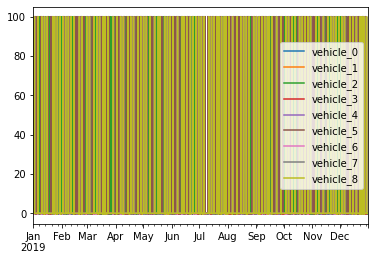

In [16]:
actions.plot()

<AxesSubplot:>

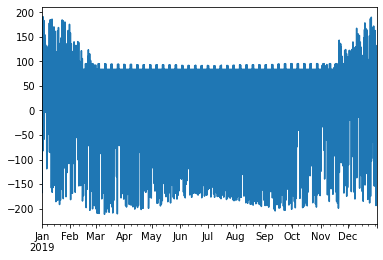

In [17]:
rewards['gridLoad'].plot()

<AxesSubplot:>

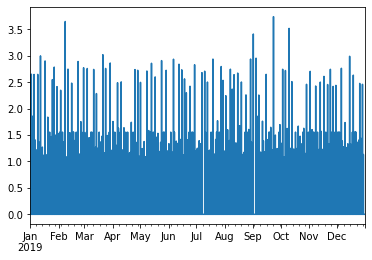

In [18]:
rewards['h2Charge'].plot()

<AxesSubplot:>

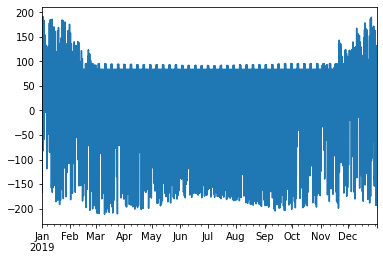

In [19]:
(states['buildingLoad'] - states['pvGeneration']).plot()